## Data Exploration

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

### Read data

In [2]:
data = pd.read_json("./new_data_format_Oct20.json")
data = data[data.index == "data"]
data

ValueError: Expected object or value

In [ ]:
meta = pd.read_json("./new_data_format_Oct20.json")
meta = meta[meta.index == "meta"]
meta = pd.json_normalize( meta['field'])

meta = meta.apply(pd.Series.explode).reset_index(drop=True)
meta

Above we can see the metadata of the signals.

In [4]:
df = pd.DataFrame()

signals = data.explode('field')['field']
for i, sig_id in enumerate(meta["signal.sig_id"]):
    df[sig_id] = signals[i]
    
    
from datetime import datetime, timedelta
start = datetime(2020, 10, 1, 1)
dates = pd.date_range(start,  start + timedelta(minutes = 44639), periods=44640)
df['date'] = dates



### Clean Data

Now that we got the PV-data, we have to examine what is there. The meta-data suggests that every signal is sampled every minute, but as there are a lot of NaN-values its hard to believe. First of all, we can observe that Modular Temperature contains almost no values, so this can be removed.  
In addtion, it looks like zero-values (e.g irridation at night) are set to nan. Therefore we fill missing values by interpolation.

In [5]:
df = df.fillna(0, limit = 1)
df = df.interpolate()

df.to_csv("./data_oct20.csv")

In [6]:
df_10 = df.iloc[::10].reset_index()

df_10.to_csv("./data_oct20_10min.csv")

### PV

In [7]:
pv = df.filter(['acuvim_PmEAct', 'Met_WdSpd', 'Met_Temp', 'Met_IrrGloHoztl', 'Met_IrrPOA'])
pv.head()

,acuvim_PmEAct,Met_WdSpd,Met_Temp,Met_IrrGloHoztl,Met_IrrPOA
0,0.000000,0.0,0.000000,0.000000,0.000000
1,0.003709,5.0,1.885714,0.017964,0.018072
2,0.007418,4.5,3.771429,0.035928,0.036145
3,0.011128,4.0,5.657143,0.053892,0.054217
4,0.014837,3.0,7.542857,0.071856,0.072289


In [8]:
pv.isna().sum()

acuvim_PmEAct      0
Met_WdSpd          0
Met_Temp           0
Met_IrrGloHoztl    0
Met_IrrPOA         0
dtype: int64

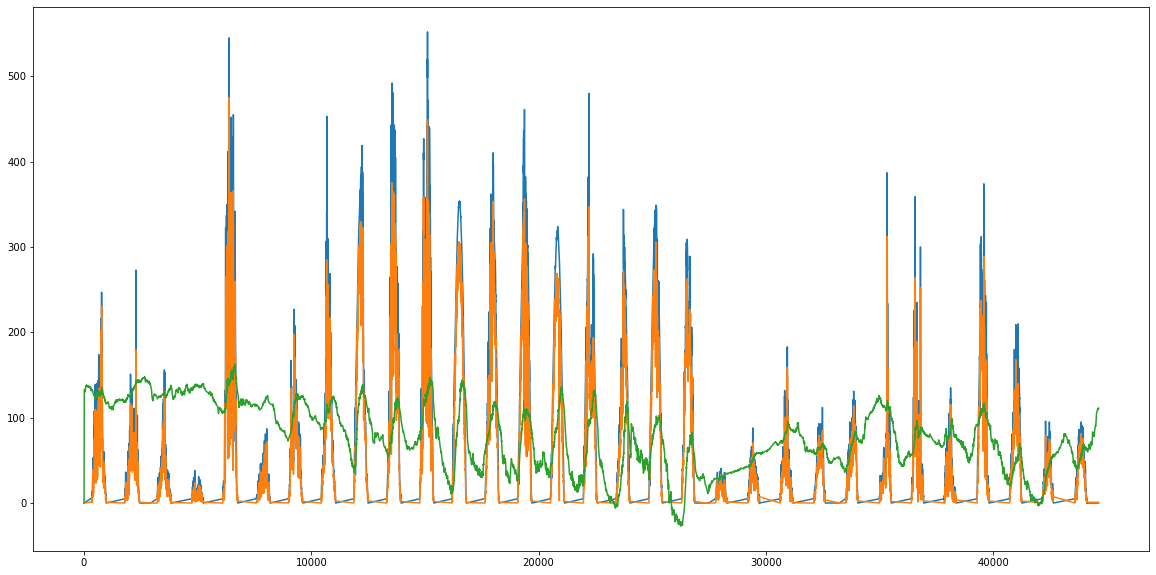

In [9]:
plt.figure(figsize= (20, 10))
plt.plot(range(44640), pv.Met_IrrGloHoztl)
plt.plot(range(44640), pv.acuvim_PmEAct)
plt.plot(range(44640), pv.Met_Temp*10)
plt.show()

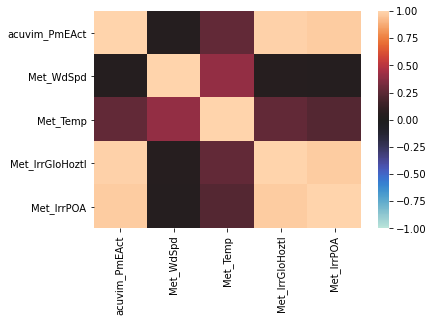

In [10]:
corr = pv.corr()
sn.heatmap(corr, vmin = -1, vmax = 1, center = 0)
plt.show()

In [11]:
corr

,acuvim_PmEAct,Met_WdSpd,Met_Temp,Met_IrrGloHoztl,Met_IrrPOA
acuvim_PmEAct,1.000000,0.043095,0.267232,0.989859,0.971814
Met_WdSpd,0.043095,1.000000,0.403404,0.047137,0.039621
Met_Temp,0.267232,0.403404,1.000000,0.271129,0.233571
Met_IrrGloHoztl,0.989859,0.047137,0.271129,1.000000,0.972649
Met_IrrPOA,0.971814,0.039621,0.233571,0.972649,1.000000


From the corrolation we can see that production is mainly driven by Global horizontal irradiance. It can also be seen that Plane of array irradiance affects it, but as correlation between this and Global is high, it does not provide more information. Production is also somewhat affected by temperature, which can be included in a model.

In [12]:
from datetime import datetime, timedelta
start = datetime(2020, 10, 1, 1)
dates = pd.date_range(start,  start + timedelta(minutes = 44639), periods=44640)
pv['date'] = dates

In [13]:
pv_reduced = pv.filter(['date','acuvim_PmEAct', 'Met_Temp', 'Met_IrrGloHoztl'])

In [14]:
pv_reduced.to_csv('./pv_red.csv', index=False)

## Observations from CAMS


In [15]:
df_obs = pd.read_csv("./uv_observations.csv", delimiter = ";", parse_dates = ['# Observation period'], infer_datetime_format= False)
df_obs.rename(columns = {'# Observation period': 'date'}, inplace = True)
df_obs.drop(df.tail(1440).index, inplace = True)

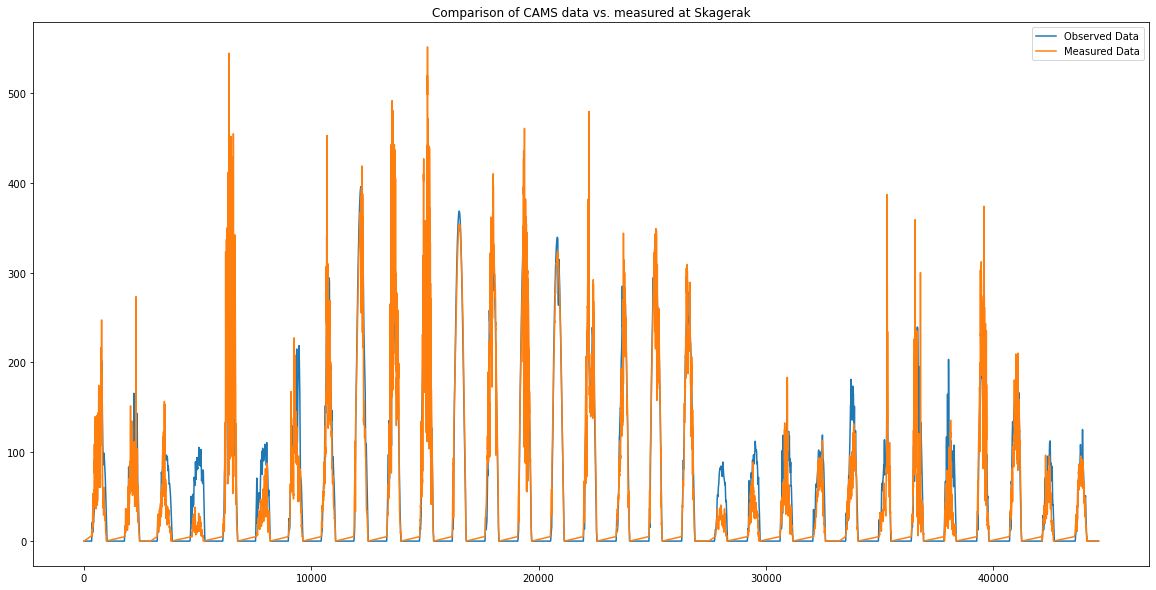

In [16]:
plt.figure(figsize = (20, 10))
plt.plot(range(df_obs.shape[0]), df_obs.GHI*60)
plt.plot(range(df_obs.shape[0]), pv.Met_IrrGloHoztl)
plt.title("Comparison of CAMS data vs. measured at Skagerak")
plt.legend(["Observed Data", "Measured Data"])
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error

In [18]:
mean_squared_error(df_obs.GHI*60, pv.Met_IrrGloHoztl)

1021.9821429192466

In [19]:
y_true = df_obs.GHI.to_numpy()*60
y_pred = pv.Met_IrrGloHoztl.to_numpy()
y_true[y_true == 0] = 0.00000001
np.mean(np.abs((y_true - y_pred) / y_true)) * 100


13783570344.497776

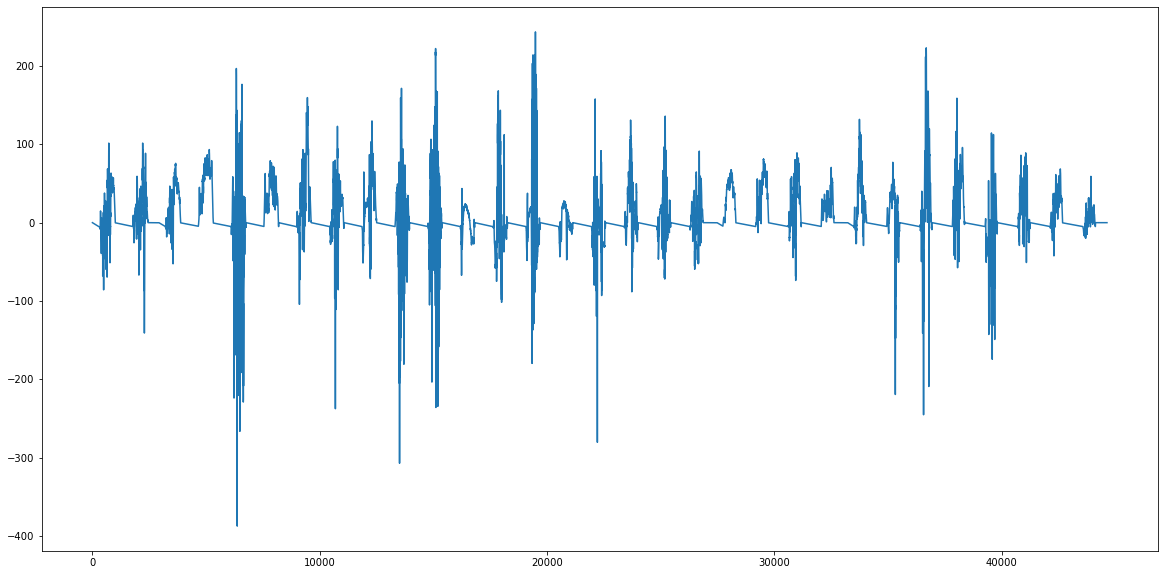

In [20]:
plt.figure(figsize = (20, 10))
plt.plot(range(df_obs.shape[0]), y_true - y_pred)
plt.show()

## Solcast

In [21]:
import solcast
url = "https://api.solcast.com.au/world_radiation/estimated_actuals?latitude=59.211437&longitude=9.589975&hours=168"
api_key = "_pcnbq8DNwn4gVIGjrgeaBOMoNqCbnJ5"

In [22]:
forecast = solcast.get_radiation_forecasts(59.211437,9.589975, api_key)

In [23]:
df_sol = pd.read_csv("./solcast_data.csv", parse_dates=['PeriodStart', "PeriodEnd"])
#df_sol = df_sol[(df_sol['PeriodEnd'] > "2020-10-01") & (df_sol['PeriodStart'] < "2020-11-01")].reset_index()
df_sol.rename(columns = {"PeriodStart": 'date'}, inplace = True)
df_sol['date'] = df_sol['date'].dt.tz_localize(None)
df_sol

,PeriodEnd,date,Period,AirTemp,CloudOpacity,Dhi,Dni,Ebh,Ghi
0,2020-08-31 00:10:00+00:00,2020-08-31 00:05:00,PT5M,7.7,55.6,0,0,0,0
1,2020-08-31 00:15:00+00:00,2020-08-31 00:10:00,PT5M,7.7,33.6,0,0,0,0
2,2020-08-31 00:20:00+00:00,2020-08-31 00:15:00,PT5M,7.7,15.5,0,0,0,0
3,2020-08-31 00:25:00+00:00,2020-08-31 00:20:00,PT5M,7.6,9.5,0,0,0,0
4,2020-08-31 00:30:00+00:00,2020-08-31 00:25:00,PT5M,7.6,4.2,0,0,0,0
...,...,...,...,...,...,...,...,...,...
20715,2020-11-10 22:25:00+00:00,2020-11-10 22:20:00,PT5M,6.7,58.8,0,0,0,0
20716,2020-11-10 22:30:00+00:00,2020-11-10 22:25:00,PT5M,6.7,58.5,0,0,0,0
20717,2020-11-10 22:35:00+00:00,2020-11-10 22:30:00,PT5M,6.7,54.9,0,0,0,0
20718,2020-11-10 22:40:00+00:00,2020-11-10 22:35:00,PT5M,6.7,41.2,0,0,0,0


In [24]:
sol = pv.merge(df_sol, how='left').dropna()
sol.head()

,acuvim_PmEAct,Met_WdSpd,Met_Temp,Met_IrrGloHoztl,Met_IrrPOA,date,PeriodEnd,Period,AirTemp,CloudOpacity,Dhi,Dni,Ebh,Ghi
0,0.000000,0.00,0.000000,0.000000,0.000000,2020-10-01 01:00:00,2020-10-01 01:05:00+00:00,PT5M,12.2,58.6,0.0,0.0,0.0,0.0
5,0.018546,3.25,9.428571,0.089820,0.090361,2020-10-01 01:05:00,2020-10-01 01:10:00+00:00,PT5M,12.1,56.3,0.0,0.0,0.0,0.0
10,0.037092,3.00,13.221428,0.179641,0.180723,2020-10-01 01:10:00,2020-10-01 01:15:00+00:00,PT5M,12.1,53.8,0.0,0.0,0.0,0.0
15,0.055638,2.60,13.257143,0.269461,0.271084,2020-10-01 01:15:00,2020-10-01 01:20:00+00:00,PT5M,12.1,51.4,0.0,0.0,0.0,0.0
20,0.074184,4.00,13.292857,0.359281,0.361446,2020-10-01 01:20:00,2020-10-01 01:25:00+00:00,PT5M,12.1,49.2,0.0,0.0,0.0,0.0


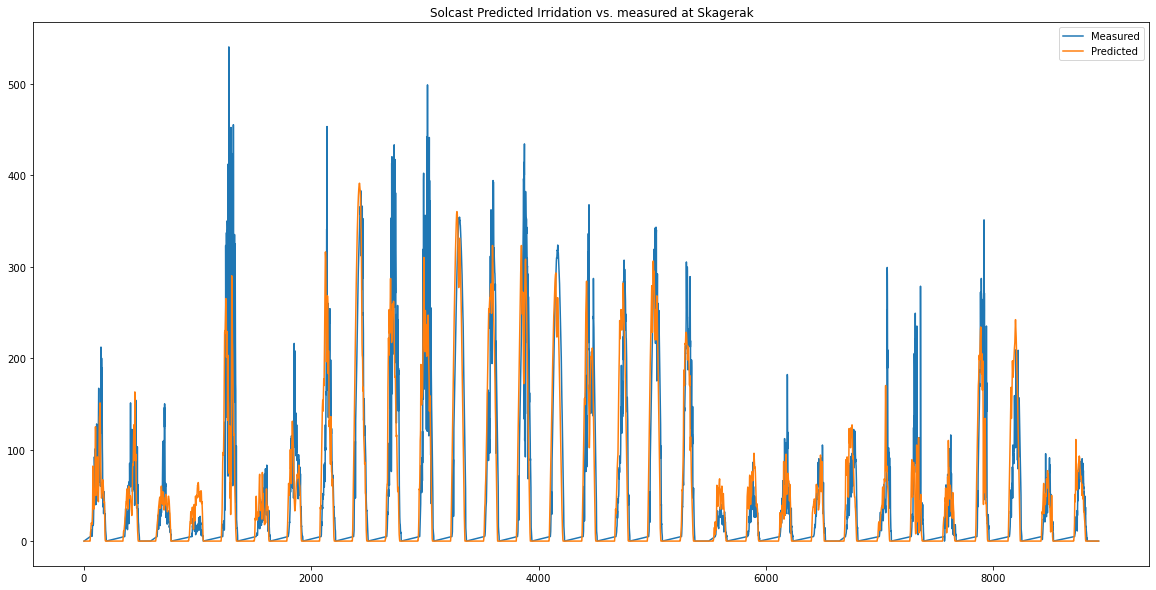

In [25]:
plt.figure(figsize = (20, 10))

plt.plot(range(sol.shape[0]), sol.Met_IrrGloHoztl)
plt.plot(range(sol.shape[0]), sol.Ghi)
plt.title("Solcast Predicted Irridation vs. measured at Skagerak")
plt.legend(["Measured", "Predicted"])
plt.show()

In [26]:
mean_squared_error(sol.Met_IrrGloHoztl, sol.Ghi)

2211.6383710847117

In [27]:
sol.corr()

,acuvim_PmEAct,Met_WdSpd,Met_Temp,Met_IrrGloHoztl,Met_IrrPOA,AirTemp,CloudOpacity,Dhi,Dni,Ebh,Ghi
acuvim_PmEAct,1.000000,0.035158,0.267517,0.988891,0.970453,0.341065,-0.270665,0.739065,0.565624,0.611880,0.833362
Met_WdSpd,0.035158,1.000000,0.397981,0.038233,0.033234,0.327729,0.125167,0.027734,0.011567,0.013671,0.025831
Met_Temp,0.267517,0.397981,1.000000,0.271135,0.233121,0.845558,0.223104,0.155219,0.040321,0.058275,0.133624
Met_IrrGloHoztl,0.988891,0.038233,0.271135,1.000000,0.972890,0.338541,-0.280785,0.731368,0.572773,0.606946,0.825536
Met_IrrPOA,0.970453,0.033234,0.233121,0.972890,1.000000,0.342688,-0.258479,0.781642,0.578470,0.636197,0.874921
AirTemp,0.341065,0.327729,0.845558,0.338541,0.342688,1.000000,0.302865,0.345488,0.109635,0.146078,0.307048
CloudOpacity,-0.270665,0.125167,0.223104,-0.280785,-0.258479,0.302865,1.000000,-0.153751,-0.453270,-0.406361,-0.337976
Dhi,0.739065,0.027734,0.155219,0.731368,0.781642,0.345488,-0.153751,1.000000,0.286301,0.322811,0.829699
Dni,0.565624,0.011567,0.040321,0.572773,0.578470,0.109635,-0.453270,0.286301,1.000000,0.948845,0.742643
Ebh,0.611880,0.013671,0.058275,0.606946,0.636197,0.146078,-0.406361,0.322811,0.948845,1.000000,0.796156


In [28]:
sol.to_csv('./pv_extended.csv')

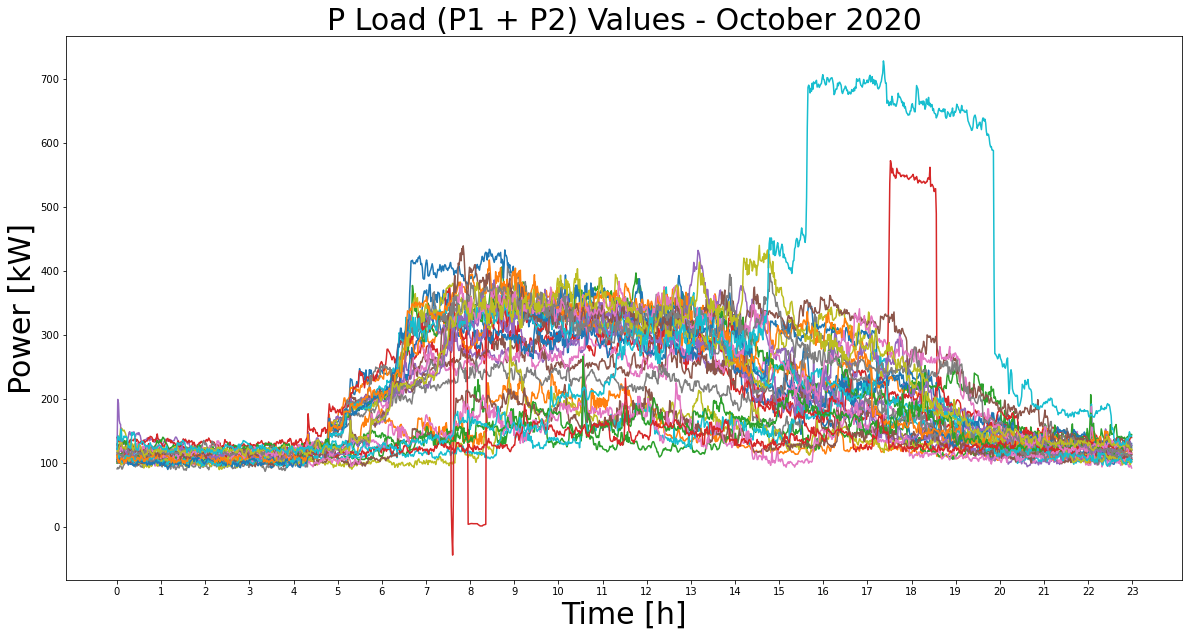

In [29]:
pv_red = df[(df['date'] >= "2020-10-02") & (df['date'] < "2020-11-01")]

plt.figure(figsize=(20,10))
t = np.arange(1440)
grouped = pv_red.groupby(pv_red.date.dt.floor('d'), as_index = False)

pv_per_day = []
pl_per_day = []

for day, group in grouped:
    plt.plot(t, group.FedPAct.values)
    pv_per_day.append(group.acuvim_PmEAct.values)
    pl_per_day.append(group.FedPAct.values)
    
#plt.plot(t, 300*np.e**-( (t-730)**2/(2*100)**2 ), lw = 10)

fontsize = 30

plt.title("P Load (P1 + P2) Values - October 2020", fontsize = fontsize)
plt.xlabel("Time [h]", fontsize = fontsize)
plt.ylabel("Power [kW]", fontsize = fontsize)
plt.xticks(np.linspace(0,1440, 24), range(24))
plt.savefig("./PL_october2020.eps", format="eps")
plt.show()


In [30]:
def plot_stats(x, title):
    mean = x.mean(axis=0)
    std = x.std(axis=0)
    max_ = x.max(axis=0)
    min_ = x.min(axis=0)

    t = range(x.shape[1])
    f = plt.figure(figsize = (10,5))
    plt.plot(t, mean)
    plt.plot(t, max_)
    plt.plot(t, min_)
    plt.fill_between(t, mean-std, mean+std, color = 'b', alpha = 0.1)
    
    fontsize = 15
    plt.title(title, fontsize = fontsize)
    plt.xlabel("Time [h]", fontsize = fontsize)
    plt.ylabel("Power [kW]", fontsize = fontsize)
    plt.legend(["Mean", "Max", "Min"], fontsize = fontsize)
    plt.xticks(np.linspace(0,1440, 24), range(24))
    return f, mean, max_, min_
    

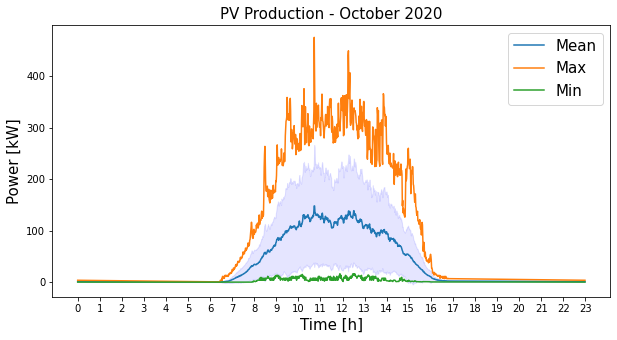

In [31]:
pv_per_day = np.asarray(pv_per_day)
f_pv_stats, pv_mean, pv_max_, pv_min_ = plot_stats(pv_per_day, "PV Production - October 2020")
f_pv_stats.savefig('../figs/PV_stats.pdf', format="pdf")

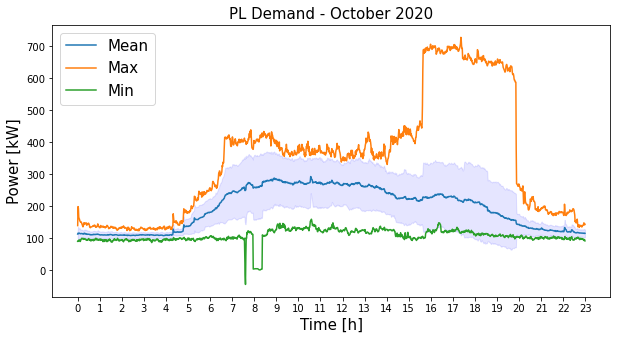

In [32]:
pl_per_day = np.asarray(pl_per_day)

f_pl_stats, pl_mean, pl_max_, pl_min_ = plot_stats(pl_per_day, "PL Demand - October 2020")
f_pl_stats.savefig('../figs/PL_stats.pdf', format="pdf")

In [41]:
df_stats = pd.DataFrame(data = {"pv_mean": pv_mean, "pv_min": pv_min_, "pv_max": pv_max_, "pl_mean": pl_mean, "pl_min": pl_min_, "pl_max": pl_max_}).iloc[::10]
df_stats.to_csv("./stats.csv")

## df = pd.DataFrame(data = {"PV": pv_min_, "PV_Pred": pv_mean, "PL": pl_max_, "PL_Pred": pl_mean})
df.to_csv('../src/sim-data/worst_case.csv')

In [ ]:
arima_df = pv.copy().set_index('date').drop(['Met_WdSpd','Met_Temp', 'Met_IrrGloHoztl', 'Met_IrrPOA'], axis = 1).iloc[0::10]
arima_train = arima_df[arima_df.index < "2020-10-02"]
arima_test = arima_df[arima_df.index >= "2020-10-29"]

arima_train

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(arima_train, order = (5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()


In [ ]:
from statsmodels.tsa.arima_model import ARIMA

def initialize_arima(train):
    model = ARIMA(train, order = (5, 1, 0))
    return model.fit(disp=0)
    
    


In [ ]:
history = arima_train.values
test = arima_test.values
predictions = []

for t in range(arima_test.shape[0]):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0][0]
    predictions.append(yhat)
    obs = test[t]
    history = np.append(history, obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

In [ ]:
plt.figure(figsize =(20, 10))
plt.plot(test)
plt.plot(predictions)

In [ ]:
def find_error_stats(df, value):
    data = df.copy()
    p = data.iloc[0::10][value].values
    a = data.iloc[1::10][value].values
    p_1 = np.zeros(p.shape)
    p_1[:a.shape[0]] = a
    
    e = p_1 - p
    #plt.figure(figsize = (20,10))
    #plt.plot(range(len(e)), e)
    return e.mean(), e.std()



grouped = pv_red.groupby(pv_red.date.dt.floor('d'), as_index = False)
means = []
stds = []
for day, group in grouped:
    group = group[group.acuvim_PmEAct > 10]
    mean, std = find_error_stats(group, 'acuvim_PmEAct')
    means.append(mean)
    stds.append(std)


In [ ]:
print(np.mean(means))
print(np.mean(stds))

find_error_stats(df, 'acuvim_PmEAct')

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(pl, auto_lag = True)

In [ ]:


def random_walk(init, length):
    
    walk = [init]
    for i in range(length):
        step = np.random.normal(0.06, 7.5)
        walk.append(np.clip(walk[i-1] + step, 0, np.inf))
    t = range(length + 1)
    plt.plot(t, walk, c='b')
    return walk
    
random_walk(40, 12)
plt.show()

In [ ]:
length = 12
for init in np.random.uniform(40, 43, 40):
    random_walk(init, length)
    
plt.show()

In [ ]:
import sklearn